# Optical field calculation using the volume integration technique

We consider the problem of light propagating in the x-y plane and being scattered by an object of infinite extent along the z axis. For light polarized along the z axis, we can skip the vectorial notation and treat the problem using the 2D scalar Helmholtz equation.

Compute the absolute value of the field E inside and outside the rectangle of width $w = 250 nm$, height $h = 1000 nm$ and dielectric constants $ε_1 = 4$ and $ε_{ref} = 1$. The incoming field is a plane wave of wavelength $λ = 633 nm$, and the angle of incidence is $θ = 0°$

![Alt text](image.png)

The structures are illuminated by an incoming wave

$$E_0(x,y) = e^{ik(xcos\theta + ysin\theta)}$$

where $k=\epsilon_{ref}^{1/2}k_0$. This is the wave travelling in air.

We would like to find the solution to the Helmholtz equation which is the sum of the incoming field and a scattered field. This can be performed by solving the integral equation:

$$ E(x,y) = E_0(x,y) + k^2 \int{G(x, y; x', y')[{\epsilon(x', y') - \epsilon_{ref}}] E(x', y') dx'dy'} $$

The integral gives a contribution only inside the structure where $\epsilon \neq \epsilon_{ref}$. This means that once the field inside the structure is known we can calculate the field everywhere else using this integral.

The 2D Green’s function $G$ is given by:

$$ G(x, y; x', y') = \dfrac{-1}{4i} H_0^{(1)}({k\sqrt{(x-x')^2 + (y-y')^2}}) $$

Here $H_0^{(1)}$ refers to the Hankel function of order 0 and first kind.

## Field inside the structure

We can compute the field inside the structure by discretizing the structure into e.g. $N$ square area elements of area $∆A$ and coordinates $(x_1, y_1)$, …, $(x_N,y_N)$. The corresponding field values are assumed to be constant within an element and are labelled $E_1$, …, $E_N$. We then have a linear system of eq.ns:

$$ E_i = E_{0, i} + k^2 \sum_j{G_{ij} [{\epsilon_j - \epsilon_{ref}}] E_j \Delta A} $$

with:

$$ G_{ij} = G(x_i, y_i; x_j, y_j) \quad, \qquad \epsilon_j = \epsilon(x_j, y_j) $$

where one has to be careful with $i$ and $j$ indices.

In the expression for $G_{ij}$, for $i = j$ we can approximate the square element to a circular element of same area $a=\sqrt{\Delta A/\pi}$ with center in $(x_i, y_i)$:

$$ G_{ii} \simeq \dfrac{-1}{2i(ak)^2}[{ka H_1^{(1)}(ka) + \dfrac{2i}{\pi}}] $$

Note that now we have a Hankel function of first kind but of order 1.

The final solution is:

$$ \overline{E} = ({\overline{\overline{I}} - k^2\Delta A \overline{\overline{G}}\overline{\overline{\epsilon}} })^{-1} \overline{E_0} $$

where $\overline{E}$ and $\overline{E_0}$ are vectors containing the elements $E_j$ and $E_{0, j}$ respectively, $\overline{\overline{G}}$ is the matrix containing elements $E_{ij}$, and $\overline{\overline{\epsilon}}$ is the diagonal matrix with the elements $\epsilon_j - \epsilon_{ref}$ along the diagonal.

In [8]:
import numpy as np

# problem constants
e1 = 4
eref = 1
l = 633                 # nm

# variable params
t = 0                   # °
trad = (np.pi/180) * t    # rad

# calculated params
k0 = 2*np.pi/l
n1 = np.sqrt(e1)
nref = np.sqrt(eref)
k1 = n1*k0
kref = nref*k0

In [2]:
from scipy.special import hankel1

# rectangle domain
w = 250                                         # nm
h = 1000                                        # nm
step = 25                                       # nm
da = step**2                                    # nm^2
a = np.sqrt(da/np.pi)                           # nm^2

x1 = np.arange(-w/2,w/2,step)                   # nm
y1 = np.arange(-h/2,h/2,step)                   # nm
e = (e1-eref)*np.eye((len(y1)*len(x1)))

X1, Y1 = np.meshgrid(x1, y1)

# unperturbed field
E0 = np.exp(1j*k0*(X1*np.cos(t) + Y1*np.sin(t)))

# build the Green function for the bare rectangle
x1x, x1y = X1.shape
g1x = x1x*x1y
G = np.zeros((g1x, g1x), dtype = 'complex_')

X1f = X1.flatten()
Y1f = Y1.flatten()

for i, xi in enumerate(X1f):
    yi = Y1f[i]
    for j, xj in enumerate(X1f):
        if i==j:
            G[j][i] = (-1/(2*1j*((a*k1)**2))) * (a*k1*hankel1(1, a*k1) + ((2*1j)/np.pi))
        else:
            yj = Y1f[j]
            zij = k1 * np.sqrt((xi - xj)**2 + (yi - yj)**2)
            G[j][i] = (-1/(4*1j))*hankel1(0, zij)

In [3]:
from scipy import sparse

# use eq. (9) to calculate the field inside the structure
I = np.identity(len(G))
M = sparse.csr_matrix(I - k1**2*da*np.matmul(G, e))
Minv = np.linalg.pinv(M.toarray())
E = np.matmul(Minv, E0.flatten())

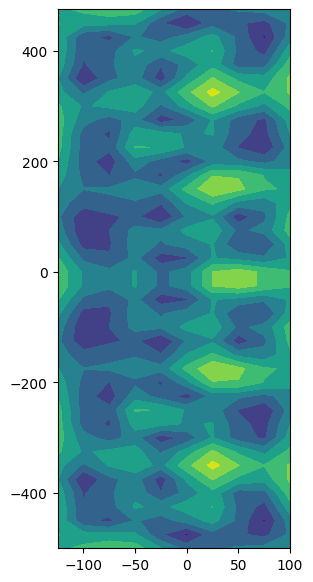

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3,7))
plt.contourf(X1, Y1, np.absolute(E.reshape(E0.shape)))

In [9]:
# defining the domain
sz = 1000                       # nm
step = 25                       # nm
x = np.arange(-sz,sz,step)      # nm
y = np.arange(-sz,sz,step)      # nm

X, Y = np.meshgrid(x, y)

E0t = np.exp(1j*k0*(X*np.cos(t) + Y*np.sin(t)))

E1m = k1**2 * np.matmul(np.matmul(G, (e - eref)),E)

# build the Green function for the bare rectangle
xtx, xty = X.shape
gtx = xtx*xty
Gt = np.zeros((gtx, g1x), dtype = 'complex_')

Xf = X.flatten()
Yf = Y.flatten()

for i, xi in enumerate(X1f):
    yi = Y1f[i]
    for j, xj in enumerate(Xf):
        yti = Yf[i]
        if i==j:
            G[j][i] = (-1/(2*1j*((a*k1)**2))) * (a*k1*hankel1(1, a*k1) + ((2*1j)/np.pi))
        else:
            yj = Y1f[j]
            zij = k1 * np.sqrt((xi - xj)**2 + (yi - yj)**2)
            G[j][i] = (-1/(4*1j))*hankel1(0, zij)

In [50]:
E1t = E0t.flatten() + E1m

plt.figure(figsize=(3,7))
plt.contourf(X, Y, np.absolute(E1t.reshape(E0t.shape)))

(59.10962810120303-8.936689905577953j)